**В этом блокноте я протестирую обученную мной LSTM на тикерах российских и иностранных компаний на разных промежутках времени**


---



Модели я буду обучать на 10-ти тикерах в период 10.03.2014-10.03.2024

Изначально я обучила модель только на данных [Open, High, Low, Close] 10-ти тикеров

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                       │ (None, 5, 160)              │         105,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 5, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_55 (LSTM)                       │ (None, 5, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 5, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_56 (LSTM)                       │ (None, 40)                  │          19,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,121 (789.54 KB)

 Trainable params: 202,121 (789.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
110/110 - 9s - 84ms/step - loss: 0.0016 - val_loss: 0.0253
Epoch 2/50
110/110 - 5s - 44ms/step - loss: 0.0351 - val_loss: 0.0042
Epoch 3/50
110/110 - 4s - 33ms/step - loss: 8.8454e-04 - val_loss: 0.0215
Epoch 4/50
110/110 - 3s - 24ms/step - loss: 0.0045 - val_loss: 0.0160
Epoch 5/50
110/110 - 4s - 40ms/step - loss: 4.2880e-04 - val_loss: 0.0161
Epoch 6/50
110/110 - 3s - 30ms/step - loss: 5.1644e-04 - val_loss: 0.0175
Epoch 7/50
110/110 - 2s - 20ms/step - loss: 5.0187e-04 - val_loss: 0.0189
Epoch 8/50
110/110 - 2s - 17ms/step - loss: 5.7518e-04 - val_loss: 0.0187
Epoch 9/50
110/110 - 3s - 24ms/step - loss: 5.9923e-04 - val_loss: 0.0206
Epoch 10/50
110/110 - 2s - 23ms/step - loss: 6.8186e-04 - val_loss: 0.0210
Epoch 11/50
110/110 - 3s - 31ms/step - loss: 7.4289e-04 - val_loss: 0.0234
Epoch 12/50
110/110 - 4s - 39ms/step - loss: 8.3674e-04 - val_loss: 0.0280
Epoch 13/50
110/110 - 3s - 23ms/step - loss: 0.0011 - val_loss: 0.0330
Epoch 14/50
110/110 - 2s - 18ms/step - loss: 9.288

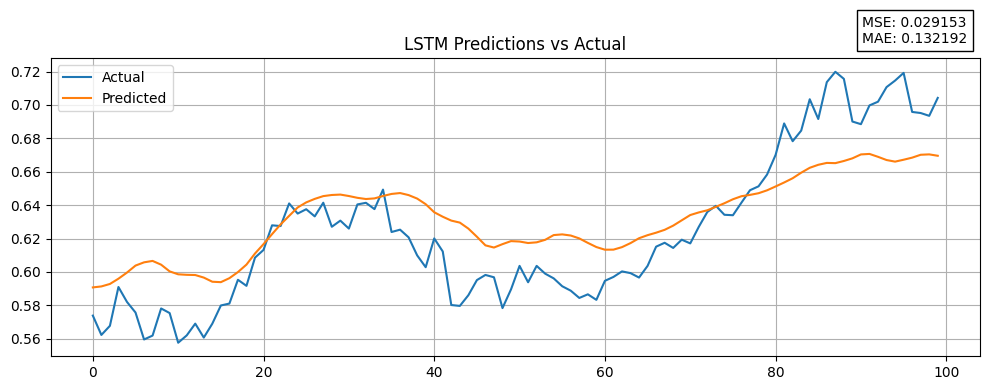

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_squared_error, mean_absolute_error



def fetch_historical_stock_data(tickers, start_date=datetime(2014, 3, 10), end_date=datetime(2024, 3, 10)):
    end_date = end_date
    start_date = start_date
    all_data = []

    for ticker in tickers:
        df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval="1d")
        df.reset_index(inplace=True)
        df = df[['Date', 'Open', 'High', 'Low', 'Close']]
        df.set_index("Date", inplace=True)
        df['Ticker'] = ticker
        all_data.append(df)

    return pd.concat(all_data)


def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg


def train_stock_model(tickers):
    df = fetch_historical_stock_data(tickers)
    dataset = df.iloc[:, :4].copy()
    values = dataset.values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values)

    reframed = series_to_supervised(values_scaled, 5, 1)
    transformed_values = reframed.values
    train_size = int(len(transformed_values) * 0.7)
    train, test = transformed_values[:train_size, :], transformed_values[train_size:, :]

    train_X, train_y = train[:, :-4], train[:, -4]
    test_X, test_y = test[:, :-4], test[:, -4]

    train_X = train_X.reshape((train_X.shape[0], 5, 4))
    test_X = test_X.reshape((test_X.shape[0], 5, 4))

    model = Sequential([
        LSTM(160, return_sequences=True, input_shape=(5, 4)),
        Dropout(0.2),
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(40),
        Dense(1, activation='relu'),
    ])

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    history = model.fit(
        train_X, train_y,
        epochs=50,
        batch_size=16,
        validation_data=(test_X, test_y),
        verbose=2,
        shuffle=False
    )

    predicted = model.predict(test_X)

    mse = mean_squared_error(test_y, predicted)
    mae = mean_absolute_error(test_y, predicted)

    print(f"Оценка на тесте:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")

    plt.figure(figsize=(10, 4))
    plt.plot(test_y[:100], label="Actual")
    plt.plot(predicted[:100], label="Predicted")
    plt.legend()
    plt.title("LSTM Predictions vs Actual")
    plt.grid(True)

    textstr = f"MSE: {mse:.6f}\nMAE: {mae:.6f}"
    anchored_text = AnchoredText(textstr, loc='lower right', prop={'size': 10},
                                 bbox_to_anchor=(1, 1),
                                 bbox_transform=plt.gca().transAxes,
                                 frameon=True)
    plt.gca().add_artist(anchored_text)

    plt.tight_layout()
    plt.savefig("lstm_simple_test_predictions.png", dpi=150)
    plt.show()

    model.save("simple_lstm_model.keras")

    return model


tickers = [
    "AAPL", "NVDA", "TSLA", "BABA", "GOOGL", "NFLX", "AMZN", "UBER", "META", "WBD"
]
model = train_stock_model(tickers)





---


Выглядит прогноз выше мягко говоря плохо - нужно исправлять. Возможно 4-x колонок признаков данных слишком мало, чтобы модель нормально обучалась.

Я решила добавить в качестве доп признаков несколько популярных технических индикаторов.

Для начала просто посмотрю влияние индикаторов на Close для тикера AAPL за первый год, который мы использовали для обучения модели.

---



[*********************100%***********************]  1 of 1 completed
<ipython-input-25-b7e2890a0bd4>:48: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  close_corr = corr_matrix.loc[:, 'Close'].drop(labels='Close')


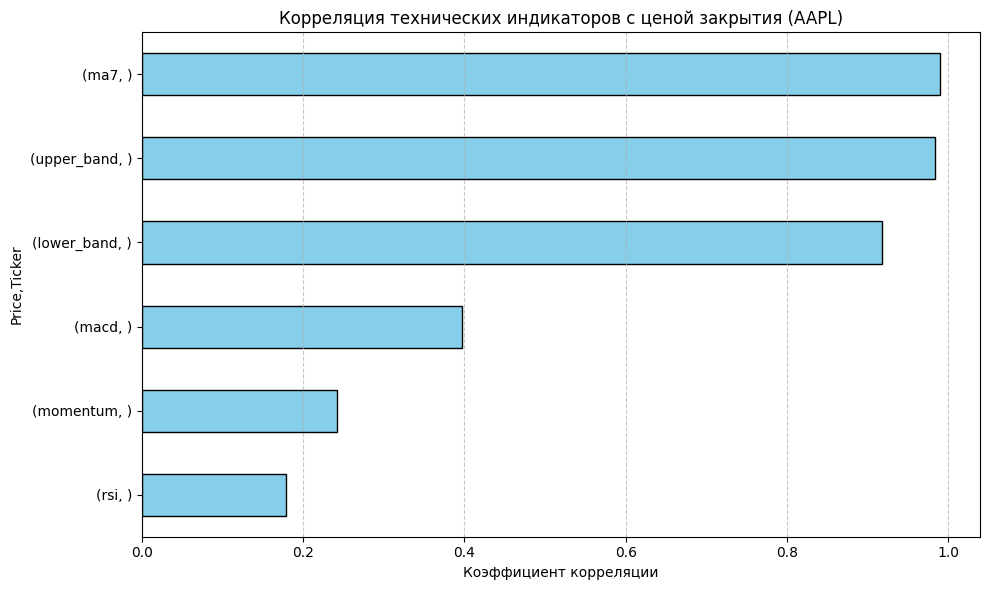

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


ticker = "AAPL"
start_date = "2014-03-10"
end_date = "2015-03-10"
df = yf.download(ticker, start=start_date, end=end_date)


df['ma7'] = df['Close'].rolling(window=7).mean()
df['ma21'] = df['Close'].rolling(window=21).mean()

df['ema'] = df['Close'].ewm(span=20, adjust=False).mean()

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

df['ma20'] = df['Close'].rolling(window=20).mean()
df['std20'] = df['Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + 2 * df['std20']
df['lower_band'] = df['ma20'] - 2 * df['std20']

df['momentum'] = df['Close'] - df['Close'].shift(10)

df.dropna(inplace=True)

indicators = [
    'ma7', 'macd', 'rsi',
    'upper_band', 'lower_band', 'momentum'
]

selected = df[indicators + ['Close']]
corr_matrix = selected.corr()


close_corr = corr_matrix.loc[:, 'Close'].drop(labels='Close')
plt.figure(figsize=(10, 6))
close_corr = close_corr.squeeze()
close_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title(f"Корреляция технических индикаторов с ценой закрытия ({ticker})")
plt.xlabel("Коэффициент корреляции")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()





---

Добавлю первые 4 индикатора в модель


---



[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is d

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 5, 160)              │         108,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 5, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 5, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 5, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 40)                  │          19,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,681 (799.54 KB)

 Trainable params: 204,681 (799.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1039/1039 - 26s - 25ms/step - loss: 0.0411 - val_loss: 0.0029
Epoch 2/50
1039/1039 - 18s - 18ms/step - loss: 0.0048 - val_loss: 0.0209
Epoch 3/50
1039/1039 - 27s - 26ms/step - loss: 0.0062 - val_loss: 0.0156
Epoch 4/50
1039/1039 - 25s - 24ms/step - loss: 0.0061 - val_loss: 0.0162
Epoch 5/50
1039/1039 - 37s - 35ms/step - loss: 0.0060 - val_loss: 0.0258
Epoch 6/50
1039/1039 - 38s - 37ms/step - loss: 0.0029 - val_loss: 0.0218
Epoch 7/50
1039/1039 - 22s - 21ms/step - loss: 0.0031 - val_loss: 0.0216
Epoch 8/50
1039/1039 - 39s - 37ms/step - loss: 0.0030 - val_loss: 0.0154
Epoch 9/50
1039/1039 - 25s - 24ms/step - loss: 0.0026 - val_loss: 0.0074
Epoch 10/50
1039/1039 - 23s - 22ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 11/50
1039/1039 - 20s - 19ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/50
1039/1039 - 26s - 25ms/step - loss: 9.1308e-04 - val_loss: 0.0019
Epoch 13/50
1039/1039 - 35s - 33ms/step - loss: 9.1993e-04 - val_loss: 0.0035
Epoch 14/50
1039/1039 - 21s - 21ms/step

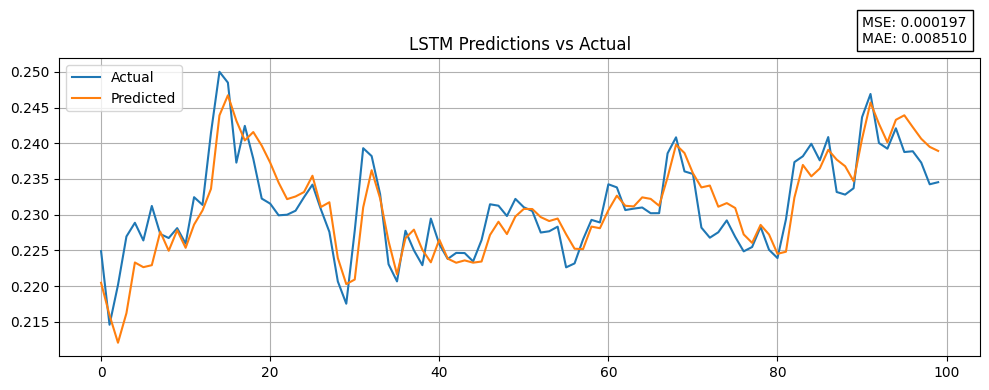

In [9]:
import yfinance as yf
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


def fetch_historical_stock_data(tickers, start_date=datetime(2014, 3, 10), end_date=datetime(2024, 3, 10)):
    end_date = end_date
    start_date = start_date
    all_data = []

    for ticker in tickers:
        df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'),
                         end=end_date.strftime('%Y-%m-%d'), interval="1d")

        if df.empty:
            print(f"Нет данных для {ticker}")
            continue

        df.reset_index(inplace=True)
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

        df = df[['Date', 'Open', 'High', 'Low', 'Close']]
        df.set_index("Date", inplace=True)

        df['ma7'] = df['Close'].rolling(window=7, min_periods=1).mean()

        df['ema12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['ema26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['ema12'] - df['ema26']

        df['std20'] = df['Close'].rolling(window=20, min_periods=1).std()
        df['upper_band'] = df['ma7'] + (df['std20'] * 2)
        df['lower_band'] = df['ma7'] - (df['std20'] * 2)

        df.drop(columns=['ema12', 'ema26', 'std20'], inplace=True)
        df.dropna(subset=['Close'], inplace=True)
        df.fillna(method="bfill", inplace=True)

        df['Ticker'] = ticker
        all_data.append(df)

    return pd.concat(all_data) if all_data else None

def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

def train_stock_model(tickers):
    df = fetch_historical_stock_data(tickers)

    if df is None or df.empty:
        return None, None

    dataset = df[['Open', 'High', 'Low', 'Close', 'ma7', 'MACD', 'upper_band', 'lower_band']].copy()
    values = dataset.values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values)

    reframed = series_to_supervised(values_scaled, 5, 1)
    transformed_values = reframed.values
    train_size = int(len(transformed_values) * 0.7)
    train, test = transformed_values[:train_size, :], transformed_values[train_size:, :]

    n_features = len(dataset.columns)
    train_X, train_y = train[:, :-n_features], train[:, -n_features]
    test_X, test_y = test[:, :-n_features], test[:, -n_features]

    train_X = train_X.reshape((train_X.shape[0], 5, n_features))
    test_X = test_X.reshape((test_X.shape[0], 5, n_features))

    model = Sequential([
        LSTM(160, return_sequences=True, input_shape=(5, n_features)),
        Dropout(0.2),
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(40),
        Dense(1, activation='relu'),
    ])

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    model.fit(
        train_X, train_y,
        epochs=50,
        batch_size=16,
        validation_data=(test_X, test_y),
        verbose=2,
        shuffle=False
    )

    model.save("lstm.keras")

    predicted = model.predict(test_X)

    mse = mean_squared_error(test_y, predicted)
    mae = mean_absolute_error(test_y, predicted)

    print(f"Оценка на тесте:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")

    plt.figure(figsize=(10, 4))
    plt.plot(test_y[:100], label="Actual")
    plt.plot(predicted[:100], label="Predicted")
    plt.legend()
    plt.title("LSTM Predictions vs Actual")
    plt.grid(True)

    textstr = f"MSE: {mse:.6f}\nMAE: {mae:.6f}"
    anchored_text = AnchoredText(textstr, loc='lower right', prop={'size': 10},
                                 bbox_to_anchor=(1, 1),
                                 bbox_transform=plt.gca().transAxes,
                                 frameon=True)
    plt.gca().add_artist(anchored_text)

    plt.tight_layout()
    plt.savefig("lstm_test_predictions.png", dpi=150)
    plt.show()
    return model

tickers = [
    "AAPL", "NVDA", "TSLA", "BABA", "GOOGL", "NFLX", "AMZN", "UBER", "META", "WBD"
]

model = train_stock_model(tickers)




---

Это сильно лучше! Оставим эту модель в качестве итоговой.
Далее проверим как она предсказывает цены на рандомном тикере, который не участвовал в обучении, за последние 30 и 365 дней

Для предсказания дня N подадим в модель дни N-5, N-4, N-3, N-2, N-1 дни и сравним предсказанные N с реальными значениями

---



In [18]:
from datetime import datetime, timedelta
import numpy as np

def predict_price_for_date(model, ticker, target_date):
    df = fetch_historical_stock_data([ticker], target_date - timedelta(days=30), target_date)
    if df is None or len(df) < 6:
        print(f"Недостаточно данных для {ticker} на {target_date}")
        return "Нет данных"

    feature_columns = ['Open', 'High', 'Low', 'Close', 'ma7', 'MACD', 'upper_band', 'lower_band']
    df = df[feature_columns].values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)

    past_data = df_scaled[-6:-1].reshape(1, 5, len(feature_columns))

    predicted_scaled = model.predict(past_data)
    predicted = np.zeros((1, len(feature_columns)))
    predicted[:, 3] = predicted_scaled[:, 0]

    predicted_price = scaler.inverse_transform(predicted)[:, 3][0]
    actual_price = df[-1][3]
    return predicted_price, actual_price


def test_model(model, ticker, days=30):
    dates = []
    actual_prices = []
    predicted_prices = []

    for i in range(days):
        target_date = datetime.today() - timedelta(days=i)
        result = predict_price_for_date(model, ticker, target_date)
        if result == "Нет данных":
            continue
        predicted_price, actual_price = result
        dates.append(target_date)
        predicted_prices.append(predicted_price)
        actual_prices.append(actual_price)

    actual_array = np.array(actual_prices)
    predicted_array = np.array(predicted_prices)

    percentage_errors = (predicted_array - actual_array) / actual_array * 100
    abs_percentage_errors = np.abs(percentage_errors)

    rmse_percent = np.sqrt(np.mean(percentage_errors ** 2))
    mae_percent = np.mean(abs_percentage_errors)

    print(f"RMSE: {rmse_percent:.2f}%")
    print(f"MAE: {mae_percent:.2f}%")

    plt.figure(figsize=(14, 7))
    plt.title(f"Сравнение реальных и предсказанных значений для {ticker}")

    plt.plot(dates, actual_prices, label="Реальные цены", color="blue")
    plt.plot(dates, predicted_prices, label="Предсказанные цены", color="red", linestyle="--")
    plt.legend()
    plt.grid()
    plt.show()





---

предсказываем 30 дней

---



[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
RMSE: 3.53%
MAE: 2.69%


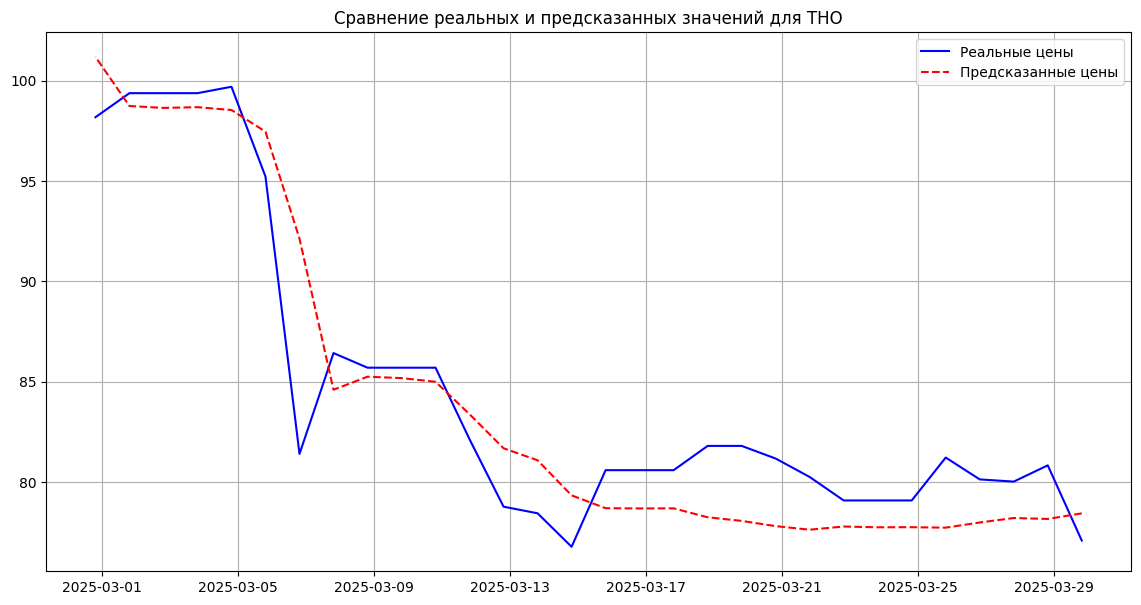

In [20]:
test_model(model, "THO", days=30)



---

смотрим предсказанные значения за год

---



[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ma7'] = df['Close'].rolling(window=7, min_periods=1).mean()
<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



<ipython-input-9-3cf98d8c2f15>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


RMSE: 2.58%
MAE: 2.05%


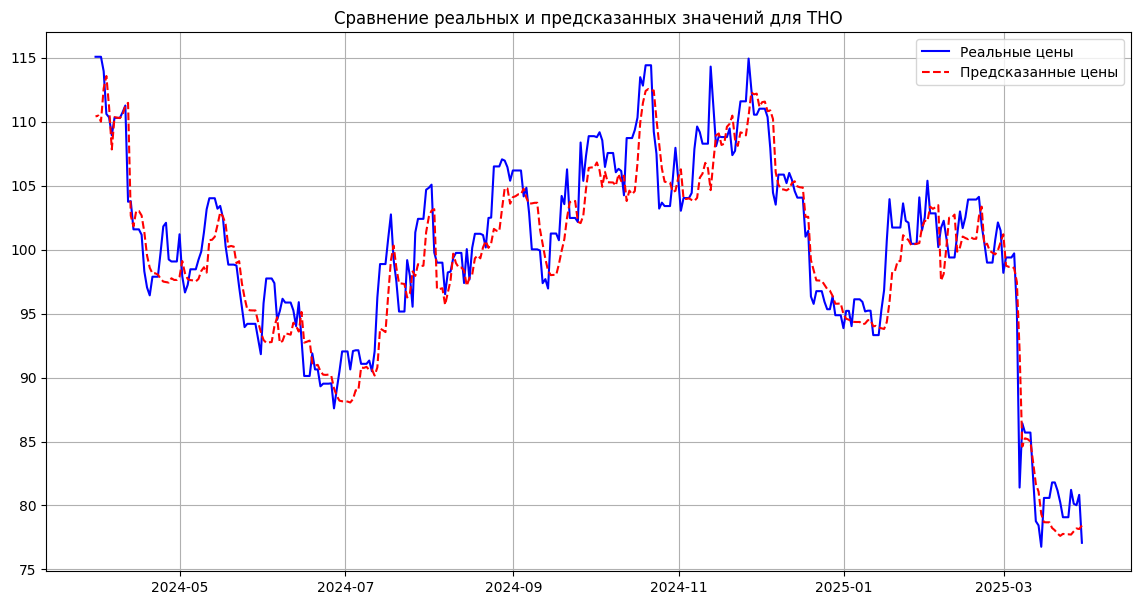

In [21]:
test_model(model, "THO", days=365)



---

Далее адаптируем сбор данных тикеров для московской биржи и также проверим, как модель предсказывает цены

---



In [26]:
import requests
import pandas as pd
from datetime import datetime
import requests
import pandas as pd


def load_moex_data(ticker, start, end):
    url = f"https://iss.moex.com/iss/engines/stock/markets/shares/securities/{ticker}/candles.json"
    params = {
        "from": start.strftime("%Y-%m-%d"),
        "till": end.strftime("%Y-%m-%d"),
        "interval": 24,
        "iss.meta": "off"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Ошибка: {response.status_code}")
        return None

    data = response.json()
    if "candles" not in data or "data" not in data["candles"]:
        print("Нет данных от MOEX")
        return None

    columns = data["candles"]["columns"]
    df = pd.DataFrame(data["candles"]["data"], columns=columns)
    df = df.rename(columns={"begin": "Date", "open": "Open", "high": "High", "low": "Low", "close": "Close"})
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    df['ma7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['ema12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['ema12'] - df['ema26']
    df['std20'] = df['Close'].rolling(window=20, min_periods=1).std()
    df['upper_band'] = df['ma7'] + 2 * df['std20']
    df['lower_band'] = df['ma7'] - 2 * df['std20']

    df.drop(columns=['ema12', 'ema26', 'std20'], inplace=True)
    df.dropna(inplace=True)

    return df[['Open', 'High', 'Low', 'Close', 'ma7', 'MACD', 'upper_band', 'lower_band']]

def predict_price_for_moex(model, ticker, target_date):
    df = load_moex_data(ticker, target_date - timedelta(days=30), target_date)
    if df is None or len(df) < 6:
        print(f"Недостаточно данных для {ticker} на {target_date}")
        return "Нет данных"

    feature_columns = ['Open', 'High', 'Low', 'Close', 'ma7', 'MACD', 'upper_band', 'lower_band']
    df = df[feature_columns].values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)

    past_data = df_scaled[-6:-1].reshape(1, 5, len(feature_columns))

    predicted_scaled = model.predict(past_data)
    predicted = np.zeros((1, len(feature_columns)))
    predicted[:, 3] = predicted_scaled[:, 0]

    predicted_price = scaler.inverse_transform(predicted)[:, 3][0]
    actual_price = df[-1][3]
    return predicted_price, actual_price

def test_model_moex(model, ticker, days=30):
    dates = []
    actual_prices = []
    predicted_prices = []

    for i in range(days):
        target_date = datetime.today() - timedelta(days=i)
        result = predict_price_for_moex(model, ticker, target_date)
        if result == "Нет данных":
            continue
        predicted_price, actual_price = result
        dates.append(target_date)
        predicted_prices.append(predicted_price)
        actual_prices.append(actual_price)

    actual_array = np.array(actual_prices)
    predicted_array = np.array(predicted_prices)

    percentage_errors = (predicted_array - actual_array) / actual_array * 100
    abs_percentage_errors = np.abs(percentage_errors)

    rmse_percent = np.sqrt(np.mean(percentage_errors ** 2))
    mae_percent = np.mean(abs_percentage_errors)

    print(f"RMSE: {rmse_percent:.2f}%")
    print(f"MAE: {mae_percent:.2f}%")

    plt.figure(figsize=(14, 7))
    plt.title(f"Сравнение реальных и предсказанных значений для {ticker}")
    plt.plot(dates, actual_prices, label="Реальные цены", color="blue")
    plt.plot(dates, predicted_prices, label="Предсказанные цены", color="red", linestyle="--")
    plt.legend()
    plt.grid()
    plt.show()




---
предсказываем 30 дней


---



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

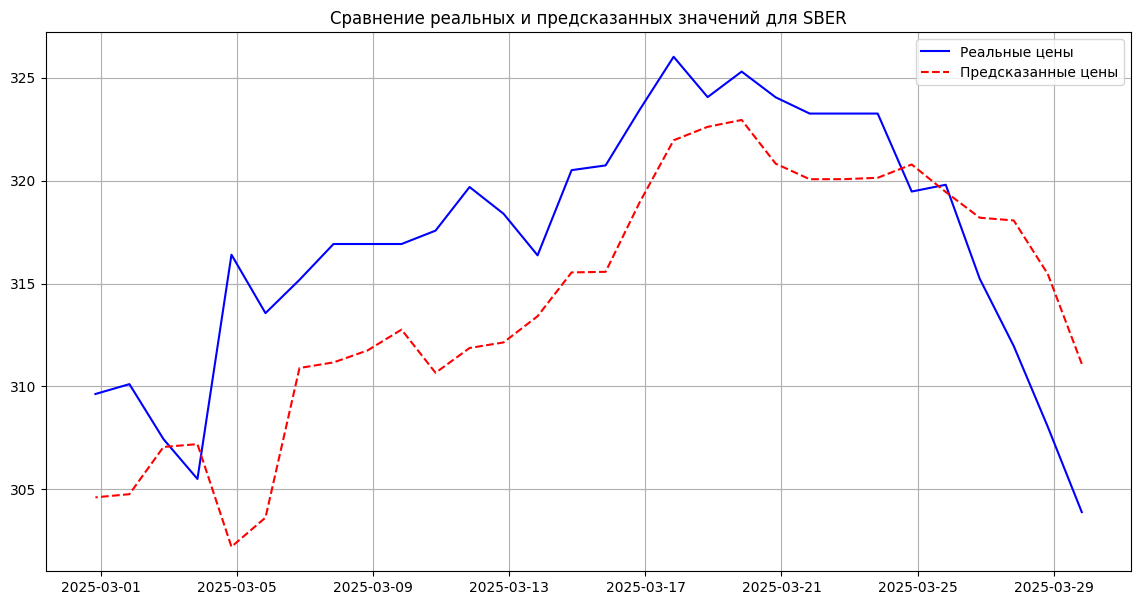

In [27]:
test_model_moex(model, "SBER", days=30)



---

смотрим предсказанные значения за год

---



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

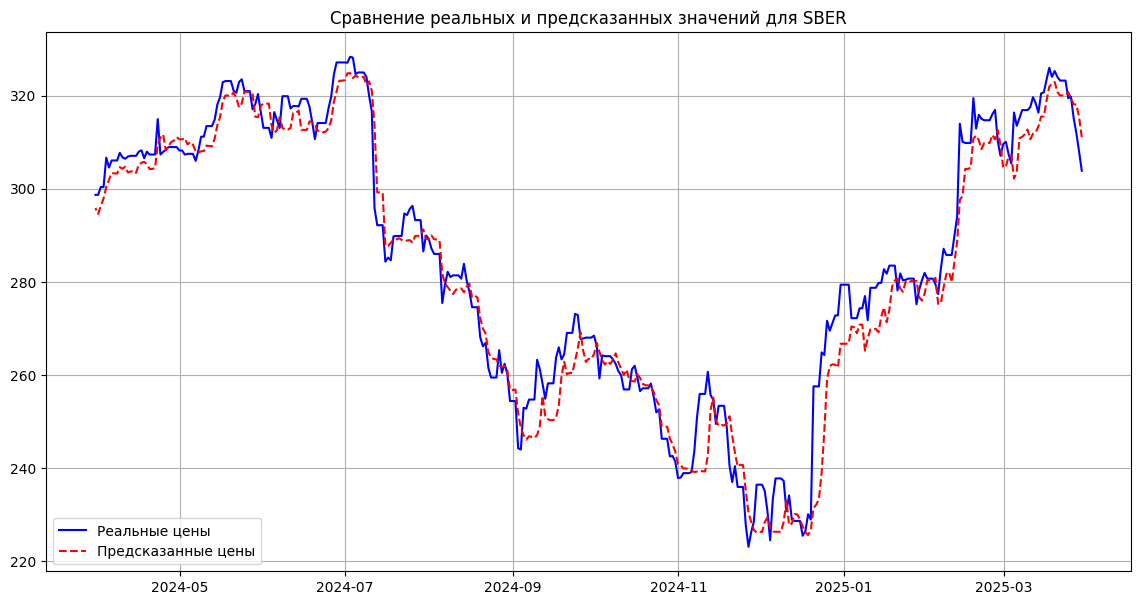

In [28]:
test_model_moex(model, "SBER", days=365)